# Purchase Prediction - Is it a Hit!

This is a classification prediction method to determine if it is possible to predict the success of a game based on a number of input tags.

The data from steam includes features relating to developers, producers, ratings, computer requirements, downloadable content, controller support, and different genre categories.

Predictions will be done for all games in Steam dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import load, dump
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
pd.options.display.max_columns = 100
pd.set_option('display.float_format', '{:.4f}'.format)

### Import Data

In [140]:
steam = pd.read_csv('datasets/steam_clean_all.csv')

### Check Label Distribution

In [144]:
steam['label'].value_counts()

<20,000    19664
>20,000     8826
Name: label, dtype: int64

### Reduce classification labels even more (maybe 4 classes intead of 12) and then use (from imblearn.over_sampling import RandomOverSampler) to make distribution equal between classes

In [145]:
steam['label'].replace({'<20,000':1, '>20,000':2},inplace=True)

In [146]:
steam['label'].value_counts(normalize=True)

1   0.6902
2   0.3098
Name: label, dtype: float64

### Split X and y

In [147]:
X = steam.drop(columns=['label']) # all features except for number of owners
y = steam['label'] # number of owners of game in categories (ranges)

### Use Imblearn to even sampling between labels

In [148]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [149]:
y_resampled.value_counts(normalize=True)

2   0.5000
1   0.5000
Name: label, dtype: float64

### Train Test Split

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)

### Scale

In [151]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

### Log Reg Model

In [15]:
params = {'C':[0.1, 10, 100], 'max_iter': [3000]}
gs_lr = GridSearchCV(LogisticRegression(),params,cv=5)
gs_lr.fit(X_train_ss,y_train)
dump(gs_lr, 'dump/gs_lr_pipe.dump')
gs_lr = load('dump/gs_lr_pipe.dump')
print(f'LogReg Best Params: {gs_lr.best_params_}')
print(f'LogReg Train Score: {gs_lr.score(X_train_ss, y_train)}')
print(f'LogReg Test Score: {gs_lr.score(X_test_ss, y_test)}')

LogReg Best Params: {'C': 10, 'max_iter': 3000}
LogReg Train Score: 0.826179820992677
LogReg Test Score: 0.8234336859235151


### KNN Model

In [16]:
params = {'n_neighbors':[8]}
gs_knn = GridSearchCV(KNeighborsClassifier(),params)
gs_knn.fit(X_train_ss,y_train)
dump(gs_knn, 'dump/gs_knn_pipe.dump')
gs_knn = load('dump/gs_knn_pipe.dump')
print(f'KNN Best Params: {gs_knn.best_params_}')
print(f'KNN Train Score: {gs_knn.score(X_train_ss, y_train)}')
print(f'KNN Test Score: {gs_knn.score(X_test_ss, y_test)}')

KNN Best Params: {'n_neighbors': 8}
KNN Train Score: 0.8589300244100895
KNN Test Score: 0.8267900732302685


### Decision Tree Model

In [17]:
params = {'max_depth':[2, 3, 4, 5],
          'min_samples_split':[2, 3, 4]}
gs_dt = GridSearchCV(DecisionTreeClassifier(),params, cv=5)
gs_dt.fit(X_train_ss,y_train)
dump(gs_dt, 'dump/gs_dt_pipe.dump')
gs_dt = load('dump/gs_dt_pipe.dump')
print(f'AdaBoost Best Params: {gs_dt.best_params_}')
print(f'AdaBoost Train Score: {gs_dt.score(X_train_ss, y_train)}')
print(f'AdaBoost Test Score: {gs_dt.score(X_test_ss, y_test)}')

AdaBoost Best Params: {'max_depth': 5, 'min_samples_split': 2}
AdaBoost Train Score: 0.8289598589639273
AdaBoost Test Score: 0.8246541903986981


### Random Forest Model

In [81]:
params = {'n_estimators':[10, 30, 50, 70, 90],
          'max_depth': [8], 
          'min_samples_split': [2, 3], 
          'min_samples_leaf': [1, 2]}
gs_rf = GridSearchCV(RandomForestClassifier(),params)
gs_rf.fit(X_train_ss,y_train)
dump(gs_rf, 'dump/gs_rf_pipe.dump')
gs_rf = load('dump/gs_rf_pipe.dump')
print(f'Random Forest Best Params: {gs_rf.best_params_}')
print(f'Random Forest Train Score: {gs_rf.score(X_train_ss, y_train)}')
print(f'Random Forest Test Score: {gs_rf.score(X_test_ss, y_test)}')

Random Forest Best Params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Random Forest Train Score: 0.7983794412801736
Random Forest Test Score: 0.7965825874694874


### AdaBoost Model

In [152]:
params = {'n_estimators':[25, 30, 35, 40],
          'learning_rate': [0.1, 0.2],
          'base_estimator': [DecisionTreeClassifier()],
          'base_estimator__max_depth' : [5]}
gs_adab = GridSearchCV(AdaBoostClassifier(),params)
gs_adab.fit(X_train_ss,y_train)
dump(gs_adab, 'dump/gs_adab_pipe.dump')
gs_adab = load('dump/gs_adab_pipe.dump')
print(f'AdaBoost Best Params: {gs_adab.best_params_}')
print(f'AdaBoost Train Score: {gs_adab.score(X_train_ss, y_train)}')
print(f'AdaBoost Test Score: {gs_adab.score(X_test_ss, y_test)}')

AdaBoost Best Params: {'base_estimator': DecisionTreeClassifier(max_depth=5), 'base_estimator__max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 40}
AdaBoost Train Score: 0.855810957417955
AdaBoost Test Score: 0.8417412530512612


### SVC Model

In [20]:
params = {'C':[0.001, 0.1, 10]}
gs_svc = GridSearchCV(SVC(),params)
gs_svc.fit(X_train_ss,y_train)
dump(gs_svc, 'dump/gs_svc_pipe.dump')
gs_svc = load('dump/gs_svc_pipe.dump')
print(f'SVC Best Params: {gs_svc.best_params_}')
print(f'SVC Train Score: {gs_svc.score(X_train_ss, y_train)}')
print(f'SVC Test Score: {gs_svc.score(X_test_ss, y_test)}')

SVC Best Params: {'C': 10}
SVC Train Score: 0.9113100081366965
SVC Test Score: 0.8681855166802278


### Save AdaBoost Model

In [24]:
clf = gs_adab.fit(X_train_ss,y_train)

In [25]:
import pickle
pickle.dump(clf, open('steam_clf.pkl', 'wb'))

### Confusion Matrix

<Figure size 1440x720 with 0 Axes>

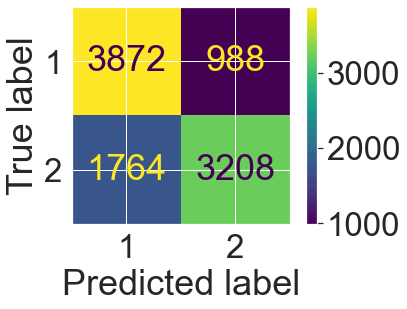

In [153]:
fig = plt.figure(figsize=[20, 10])
plot_confusion_matrix(gs_adab, X_test, y_test);

In [154]:
pred = gs_adab.predict(X_test)

In [155]:
pred

array([2, 2, 2, ..., 1, 2, 1])

In [156]:
y_test

37127    2
37969    2
35455    2
34234    2
35618    2
        ..
24117    1
2796     1
23082    1
37801    2
35509    2
Name: label, Length: 9832, dtype: int64

In [158]:
confusion_matrix(y_test, # True values.
                 pred)

array([[3872,  988],
       [1764, 3208]])

### Classification Metrics

In [164]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

In [165]:
tn, fp, fn, tp

(3872, 988, 1764, 3208)

In [171]:
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.7967


In [167]:
# What is the sensitivity of our test set?

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.6452


In [168]:
# What is the precision of our test set?

prec = tp / (tp + fp)

print(f'Precision: {round(prec,4)}')

Precision: 0.7645


In [169]:
# What is the misclassification of our test set?

misclass = (fp + fn) / (tp + fp + tn + fn)

print(f'Misclassification: {round(misclass,4)}')

Misclassification: 0.2799


In [170]:
# What is the accuracy of our test set?

acc = (tp + tn) / (tp + fp + tn + fn)

print(f'Accuracy: {round(acc,4)}')

Accuracy: 0.7201


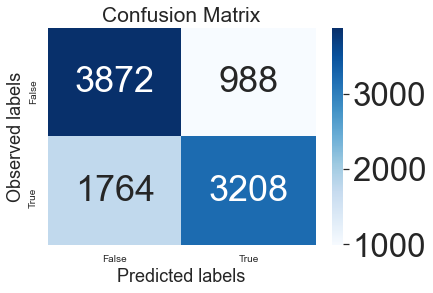

<Figure size 576x720 with 0 Axes>

In [172]:
cm = confusion_matrix(y_test, pred)

ax = plt.subplot()
plt.figure(figsize=[8,10])
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);
plt.show()

In [173]:
pred_proba = [i[0] for i in gs_adab.predict_proba(X_test)] # returns two results: negative class and positive class

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

pred_df

,true_values,pred_probs
37127,2,0.4170
37969,2,0.4120
35455,2,0.3941
34234,2,0.1317
35618,2,0.5008
...,...,...
24117,1,0.5732
2796,1,0.7840
23082,1,0.5782
37801,2,0.4690


In [174]:
# Calculate ROC AUC.
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.23599076639882932

## Function for models with coef_ parameter 

In [26]:
def coef_column(gs, num_labels):

    df_new = pd.DataFrame()
    log_odds = gs.best_estimator_.coef_[0]
    odds = np.exp(log_odds)
    df_new = pd.DataFrame(odds, 
                 X.columns, 
                 columns=['coef_' + str(0)])\
                .sort_values(by='coef_' + str(0), ascending=False)
    df_old = df_new
    return df_new

## Function for models with feature importance parameter 

In [27]:
def feature_column(gs):

    df_new = pd.DataFrame()
    features = gs.best_estimator_.feature_importances_
    df_new = pd.DataFrame(features,
                          X.columns, 
                 columns=['features'])\
                .sort_values(by='features', ascending=False)
        
    df_new = df_new.sort_values(by='features', ascending=False)
    return df_new

### Feature Importance

In [28]:
df_coef_lr = coef_column(gs_lr, 1)
df_coef_lr.rename(columns={'coef_0':'lr_coef'},inplace=True)

In [29]:
df_coef_dt = feature_column(gs_dt)
df_coef_dt.rename(columns={'features':'dt_features'},inplace=True)

In [30]:
df_coef_rf = feature_column(gs_rf)
df_coef_rf.rename(columns={'features':'rf_features'},inplace=True)

In [37]:
df_coef_adab = feature_column(gs_adab)
df_coef_adab.rename(columns={'features':'adab_features'}, inplace=True)
df_coef_adab

,adab_features
recommendations,0.1283
language_count,0.1124
free_to_play,0.0531
steam_trading_cards,0.0515
dlc,0.0400
reviews,0.0327
website,0.0322
steam_achievements,0.0316
local_multi_player,0.0308
indie,0.0294


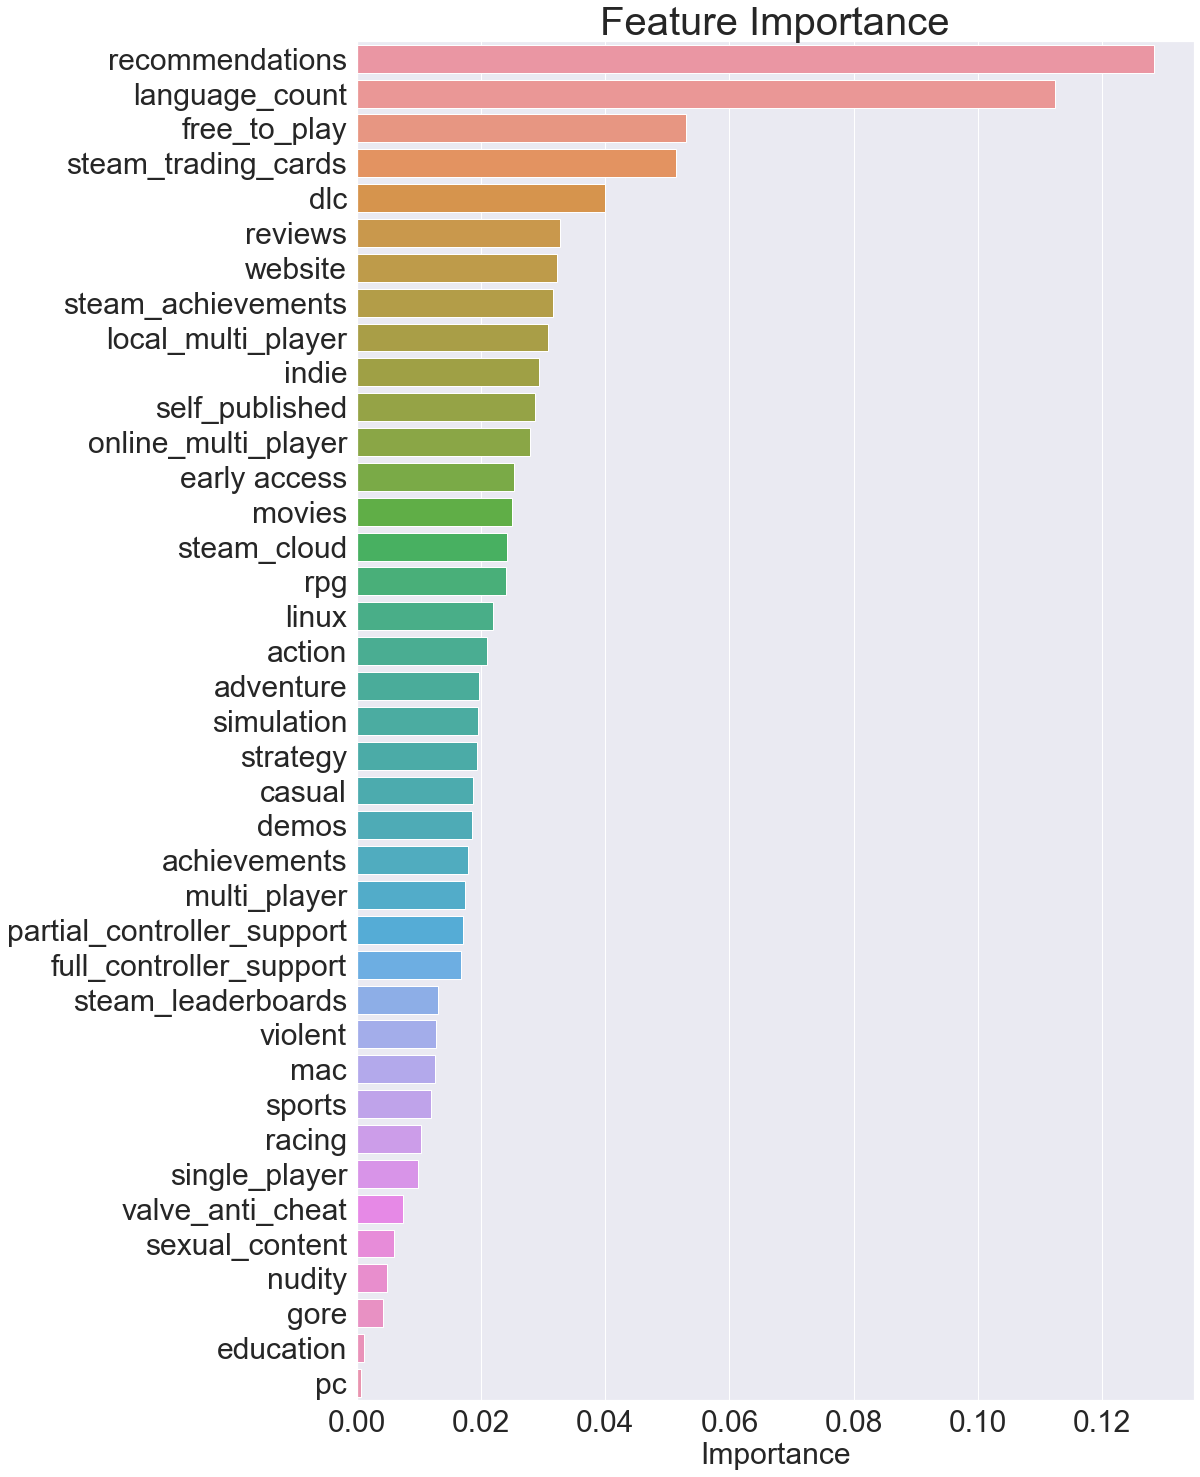

In [61]:
# Plot 20 most played games
sns.set()
fig=plt.figure(figsize=(15, 25))
p = sns.barplot(x=df_coef_adab['adab_features'] ,y=df_coef_adab.index)
p.set_xlabel("Importance", fontsize = 30)
plt.xticks(fontsize=30)
p.set_ylabel('', fontsize = 30)
plt.yticks(fontsize=30)
p.set_title("Feature Importance", fontsize = 40);
#Saving the plot as an image
fig.savefig('images/feature_importance.jpg', bbox_inches='tight', dpi=150);